In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from keras.datasets import mnist

import matplotlib.pyplot as plt

import warnings
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import os
from tqdm import tqdm

# suppress warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data

In [ ]:
def lire_alpha_digit(chars):
    alpha_digits = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)


def lire_mnist(subsample_size=-1):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # subsample
    if subsample_size != -1:
        X_train = X_train[:subsample_size]
        y_train = y_train[:subsample_size]

    # to binary and flatten
    X_train_bin = (X_train >= 128).astype(int).reshape(X_train.shape[0], -1)
    X_test_bin = (X_test >= 128).astype(int).reshape(X_test.shape[0], -1)

    # one hot encode
    y_train = one_hot_encode(y_train)
    y_test = one_hot_encode(y_test)
    return X_train_bin, X_test_bin, y_train, y_test

# Utils

In [ ]:
def one_hot_encode(y):
    unique_labels = np.unique(y)
    y_ohe = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(y.shape[0]):
        y_ohe[i, np.where(unique_labels == y[i])] = 1
    return y_ohe


def char(idx):
    if 0 <= idx <= 9:
        return chr(idx + 48)
    else:
        return chr(idx + 55)

# Plot utils

In [ ]:
def plot_data(X, y=None, save=False):
    perm = np.random.permutation(X.shape[0])
    plt.figure()
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[perm[i]], cmap="gray")
        if y is not None:
            plt.xlabel(char(y[perm[i]]))
    plt.tight_layout()
    if save:
        plt.savefig(f"{save}.pdf")
    plt.show()


def plot_batched_images(batched_images, variables, save=False):
    plt.figure(figsize=(4 * 1.5, len(variables) * 1.5))
    for i, images in enumerate(batched_images):
        for j, img in enumerate(images):
            plt.subplot(len(images), len(batched_images), i + 1 + j * len(variables))
            plt.imshow(img, cmap="gray")
            if j == 0:
                plt.title(f"{variables[i]}")
            plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(f"{save}.pdf")
    plt.show()


def plot_preds(y_true, y_pred, save=False):
    num_cols = 3
    num_rows = 3

    # random permutation on test set
    perm = np.random.permutation(len(y_true))

    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_rows * num_cols):
        idx = perm[i]
        true_label = np.argmax(y_true[idx])
        predictions_array = y_pred[idx]
        predicted_label = np.argmax(predictions_array)

        if true_label == predicted_label:
            color = "blue"
        else:
            color = "red"

        # image
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_test[idx].reshape(28, 28), cmap=plt.cm.gray)
        plt.xlabel(
            "truth={}, pred={}, score={:2.0f}".format(
                true_label,
                predicted_label,
                100 * np.max(predictions_array),
                color=color,
            )
        )

        # probs
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        bp = plt.bar(range(10), predictions_array, color="#777777")
        bp[predicted_label].set_color("red")
        bp[true_label].set_color("blue")
        plt.ylim([0, 1])

    if save:
        plt.savefig(f"{save}.pdf")

    plt.show()

# Functions

In [ ]:
def softmax(x):
    """
    Calcule la fonction softmax.
    """
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T


def sigmoid(x):
    """
    Calcule la fonction sigmoïde.
    """
    return 1 / (1 + np.exp(-x))


def calcul_softmax(layer, X):
    """
    Calcule les probabilités sur les unités de sortie à partir de la fonction softmax. Cette fonction retournera les probabilités sur les unités de sortie et prendra en argument un RBM et des données d'entrée.
    """
    return softmax(np.dot(X, layer.W) + layer.b)

# RBM

In [ ]:
class RBM:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.01, (p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)


def init_RBM(p, q):
    """
    Construit et initialise les poids et les biais d'un RBM. Cette fonction retournera une structure RBM avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    rbm = RBM(p, q)
    return rbm


def entree_sortie_RBM(rbm, X):
    """
    Calcule la valeur des unités de sortie d'un RBM à partir des données d'entrée et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(X, rbm.W) + rbm.b)


def sortie_entree_RBM(rbm, H):
    """
    Calcule la valeur des unités d'entrée d'un RBM à partir des données de sortie et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(H, rbm.W.T) + rbm.a)


def train_RBM(rbm, X, epochs, lr, batch_size):
    """
    Apprend un RBM par l'algorithme Contrastive-Divergence-1. Cette fonction retournera un structure
    RBM et prendra en argument une structure RBM, le nombre d'itérations de la descente de gradient (epochs),
    le learning rate, la taille du mini-batch, des données d'entrées...
    """
    print("Training RBM...")
    n = X.shape[0]
    p, q = rbm.W.shape
    for epoch in tqdm(range(epochs)):
        X_copy = np.copy(X)
        np.random.shuffle(X_copy)
        for i in range(0, n, batch_size):
            v_0 = X[i : i + batch_size]
            tb = len(v_0)
            es_v_0 = entree_sortie_RBM(rbm, v_0)
            h_0 = (np.random.uniform(size=(tb, q)) < es_v_0).astype("float")
            v_1 = (
                np.random.uniform(size=(tb, p)) < sortie_entree_RBM(rbm, h_0)
            ).astype("float")
            h_1 = entree_sortie_RBM(rbm, v_1)
            rbm.W += lr / tb * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
            rbm.a += lr / tb * np.sum(v_0 - v_1, axis=0)
            rbm.b += lr / tb * np.sum(es_v_0 - h_1, axis=0)
    return rbm


def generer_image_RBM(rbm, n_iter, n_image):
    """
    Génère des échantillons suivant un RBM. Cette fonction retournera et affichera les images générées et prendra en argument une structure de type RBM, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    p, q = rbm.W.shape
    X = (np.random.uniform(size=(n_image, p)) < 0.5).astype("float")
    for i in range(n_iter):
        H = (np.random.uniform(size=(n_image, q)) < entree_sortie_RBM(rbm, X)).astype(
            "float"
        )
        X = (np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(rbm, H)).astype(
            "float"
        )
    return X

# DBN

In [ ]:
class DBN:
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 1):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))

    def __len__(self):
        return len(self.layers)

    def __getitem__(self, i):
        return self.layers[i]

    def __setitem__(self, i, layer):
        self.layers[i] = layer


def init_DBN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DBN. Cette fonction retournera un DBN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dbn = DBN(n_layers)
    return dbn


def train_DBN(dbn, X_init, epochs, lr, batch_size):
    """
    Apprend un DBN par la méthode Greedy Layer-Wise. Cette fonction retournera un DBN pré-entrainé et prendra en argument un DBN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    print("Training DBN...")
    X = X_init
    for rbm in dbn:
        rbm = train_RBM(rbm, X, epochs, lr, batch_size)
        X = entree_sortie_RBM(rbm, X)
    return dbn


def generer_image_DBN(dbn, n_iter, n_image):
    """
    Génère des échantillons suivant un DBN. Cette fonction retournera et affichera les images générées et prendra en argument un DBN pré-entrainé, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    X = generer_image_RBM(dbn[-1], n_iter, n_image)
    for i in range(len(dbn) - 2, -1, -1):
        p, q = dbn[i].W.shape
        X = (
            np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(dbn[i], X)
        ).astype("float")
    return X

# DNN

In [ ]:
class FC:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.1, (p, q))
        self.b = np.zeros(q)


class DNN(DBN):
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 2):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))
        self.layers.append(FC(n_layers[-2], n_layers[-1]))


def init_DNN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DNN. Cette fonction retournera un DNN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dnn = DNN(n_layers)
    return dnn


def pretrain_DNN(dnn, X_init, epochs, lr, batch_size):
    """
    Pré-entraine un DNN. Cette fonction retournera un DNN pré-entrainé et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    print("Pretraining DNN...")
    X = X_init
    for rbm in dnn[:-1]:
        rbm = train_RBM(rbm, X, epochs, lr, batch_size)
        X = entree_sortie_RBM(rbm, X)
    return dnn


def entree_sortie_reseau(dnn, X):
    """
    Calcule les sorties sur chaque couche du réseau (couche d'entrée inclue) ainsi que les probabilités sur les unités de sortie. Cette fonction retournera une liste contenant les sorties sur chaque couche du réseau ainsi que les probabilités sur les unités de sortie et prendra en argument un DNN et des données d'entrée.
    """
    sorties = [X]
    for rbm in dnn[:-1]:
        sorties.append(entree_sortie_RBM(rbm, sorties[-1]))
    sorties.append(calcul_softmax(dnn[-1], sorties[-1]))
    return sorties


def retropropagation(dnn, X, y, epochs, lr, batch_size, verbose):
    """
    Estime les poids/biais du réseau à partir de données labellisées. Cette fonction retournera un DNN et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrée, leur label,...
    """
    print("Training DNN...")
    for epoch in tqdm(range(epochs)):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            tb = len(X_batch)
            sortie = entree_sortie_reseau(
                dnn,
                X_batch,
            )
            # compute dL/dZ
            d_Z = sortie[-1] - y_batch

            for j in range(len(dnn) - 1, -1, -1):
                grad_W = 1 / tb * np.dot(sortie[j].T, d_Z)
                grad_b = 1 / tb * np.sum(d_Z, axis=0)

                # update W and b
                dnn.layers[j].W -= lr * grad_W
                dnn.layers[j].b -= lr * grad_b

                if j == 0:  # no need to compute at last iteration
                    break

                # compute dL/dA and dL/dZ
                d_A = np.dot(d_Z, dnn[j].W.T)
                d_Z = d_A * sortie[j] * (1 - sortie[j])
            cross_entropy = -np.mean(np.sum(y_batch * np.log(sortie[-1]), axis=1))
        if verbose == 2:
            print(f"Epoch {epoch} - CE:", cross_entropy)
    return dnn


def test_DNN(dnn, X, y):
    """
    Teste les performances du réseau appris. Cette fonction retournera le taux d'erreur et prendra en argument un DNN appris, un jeu de données test, et les vrais labels associés.
    """
    sortie = entree_sortie_reseau(dnn, X)
    # Compute cross entropy
    cross_entropy = -np.mean(np.sum(y * np.log(sortie[-1]), axis=1))
    return sortie[-1], cross_entropy

# Run

In [ ]:
def RBM_main(
    X,
    width: int,
    height: int,
    q: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):

    rbm = init_RBM(p=width * height, q=q)
    
    train_RBM(rbm, X, epochs, lr, batch_size)

    X_gen = generer_image_RBM(rbm, 100, n_images).reshape(-1, width, height)
    return X_gen

In [ ]:
def DBN_main(
    X,
    n_layers,
    width: int,
    height: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):
    dbn = init_DBN(n_layers)

    train_DBN(dbn, X, epochs, lr, batch_size)

    X_gen = generer_image_DBN(dbn, 100, n_images).reshape(-1, width, height)
    return X_gen

In [ ]:
def DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers,
    lr,
    batch_size,
    pretrain_iter,
    train_iter,
    show_preds=False,
    verbose=1,
):
    # Initialisation du DNN
    dnn = init_DNN(n_layers)

    # Pré-entrainement du DNN
    print('pré-entrainement')
    if pretrain_iter:
        dnn = pretrain_DNN(dnn, X_train, pretrain_iter, lr, batch_size)

    # Entrainement du DNN
    print('entrainement')
    dnn = retropropagation(
        dnn, X_train, y_train, train_iter, lr, batch_size, verbose
    )

    # Test du DNN
    print('test')
    y_pred, cross_entropy = test_DNN(dnn, X_test, y_test)
    score = accuracy_score(
        np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)
    )

    if verbose >= 1:
        print("accuracy_score", score)

    if show_preds:
        plot_preds(y_test, y_pred, save="mnist_preds_with_prob")

    return cross_entropy, score

# Etude sur Binary AlphaDigit

In [ ]:
alphadigit = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]

X, y = lire_alpha_digit(chars=alphadigit)
height = 20
width = 16

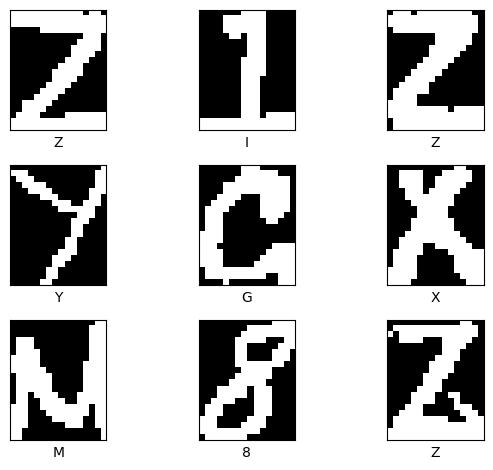

In [ ]:
plot_data(X.reshape(-1, height, width), y, save="binary_alphadigit")

# Nombre de neurones

In [ ]:
digit = [str(i) for i in range(2, 10)]
X, y = lire_alpha_digit(chars=digit)

n_neurons = range(100, 701, 200)

epochs = 100
lr = 0.1
batch_size = 10

rbm_images = []
dbn_images = []

for n in n_neurons:
    print(f"--- {n} neurons by layer ---")

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        n,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 4, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        [320, n, n],
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 100 neurons by layer ---
--- 300 neurons by layer ---
--- 500 neurons by layer ---
--- 700 neurons by layer ---


RBM


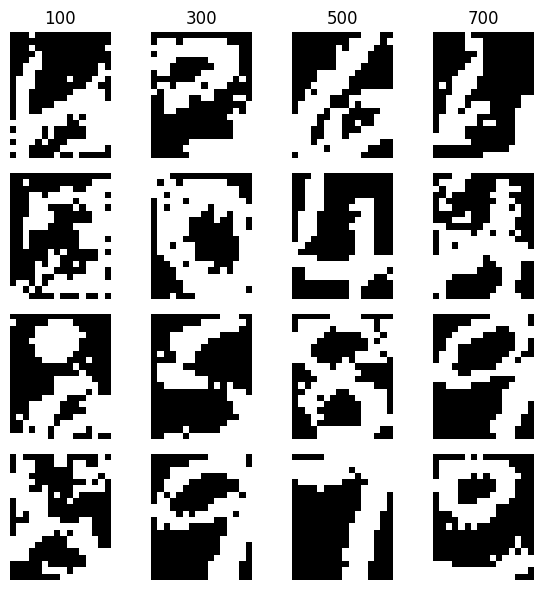

DBN


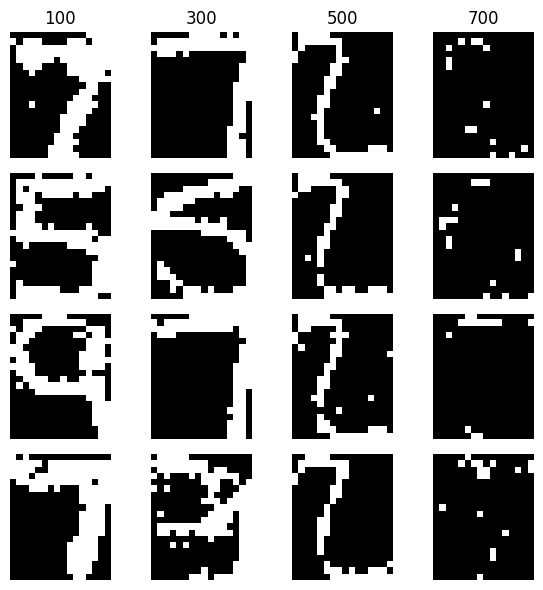

In [ ]:
print("RBM")
plot_batched_images(rbm_images, n_neurons, save="rbm_n_neurons")

print("DBN")
plot_batched_images(dbn_images, n_neurons, save="dbn_n_neurons")

# Nombre de couches

In [ ]:
digit = [str(i) for i in range(2, 10)]
X, y = lire_alpha_digit(chars=digit)

n_layers = range(2, 6)

epochs = 100
lr = 0.1
batch_size = 10
q = 200

dbn_images = []

for n in n_layers:
    print(f"--- {n} layers ---")
    layers = [200] * n

    X_gen_dbn = DBN_main(
        X,
        [320] + layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 2 layers ---
--- 3 layers ---
--- 4 layers ---
--- 5 layers ---


DBN


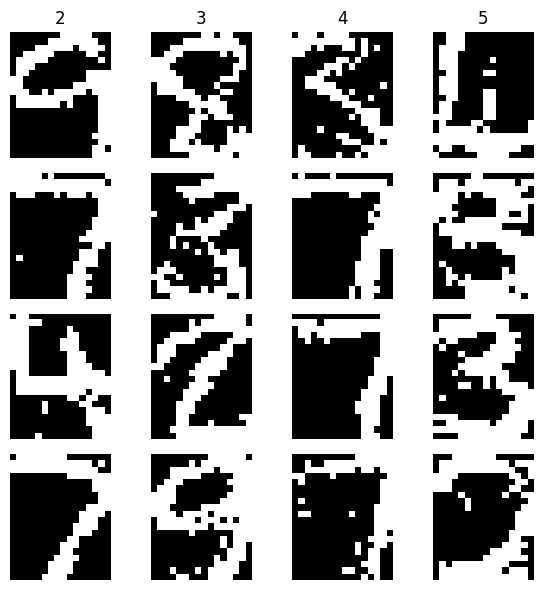

In [ ]:
print("DBN")
plot_batched_images(dbn_images, n_layers, save="dbn_n_layers")

# Nombre de caractères

In [ ]:
small = ["2", "3", "4"]
medium = [str(i) for i in range(2, 10)]
large = [chr(i) for i in range(65, 91)]

print("Small:", small)
print("Medium:", medium)
print("Large:", large)

Small: ['2', '3', '4']
Medium: ['2', '3', '4', '5', '6', '7', '8', '9']
Large: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
epochs = 100
lr = 0.1
batch_size = 10
q = 200
n_layers = [320, 200, 200]

rbm_images = []
dbn_images = []

for size, chars in zip(["small", "medium", "large"], [small, medium, large]):
    print("--- Size:", size, "---")
    X, y = lire_alpha_digit(chars=chars)

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        q,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 4, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        n_layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- Size: small ---
--- Size: medium ---
--- Size: large ---


RBM


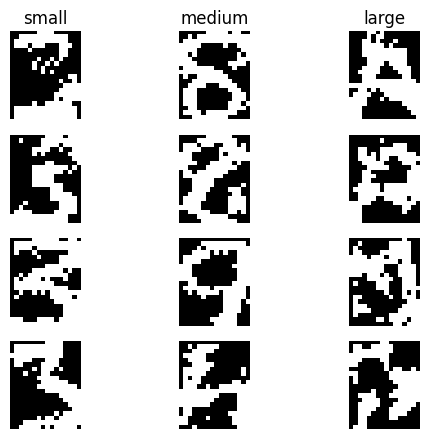

DBN


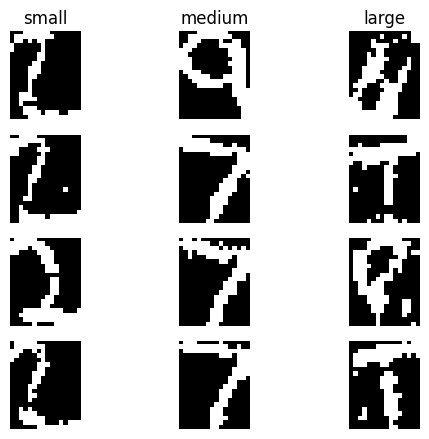

In [ ]:
print("RBM")
plot_batched_images(rbm_images, ["small", "medium", "large"], save="rbm_dataset_size")

print("DBN")
plot_batched_images(dbn_images, ["small", "medium", "large"], save="dbn_dataset_size")

# Etude sur MNIST

In [ ]:
X_train, X_test, y_train, y_test = lire_mnist(subsample_size=-1)

batch_size = 2000
lr = 0.1
n_layers = [784, 200, 10]
pretrain_iter = 100
train_iter = 200

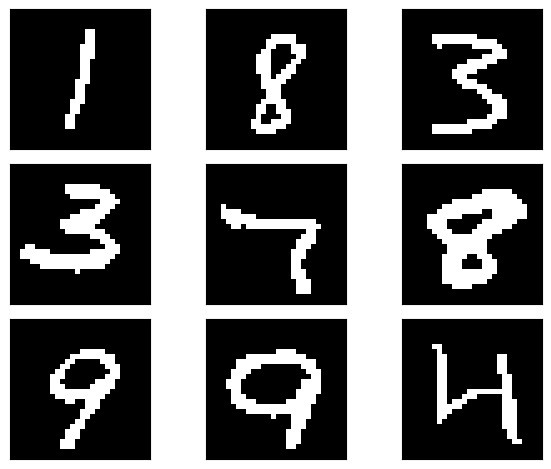

In [ ]:
plot_data(X_train.reshape(-1, 28, 28), save="mnist")

entrainement


100%|██████████| 200/200 [01:47<00:00,  1.87it/s]


test
f1_score 0.8642


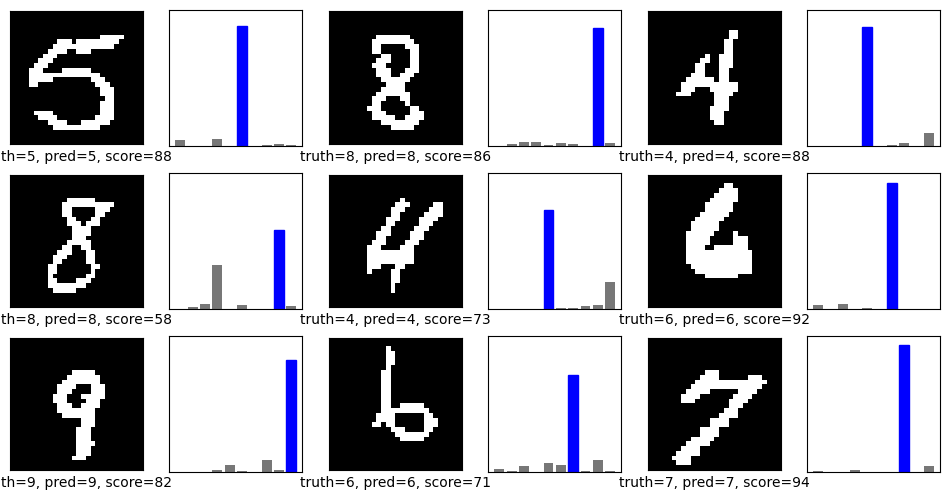

In [ ]:
ce, score = DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=[784, 5, 10],
    lr=lr,
    batch_size=batch_size,
    pretrain_iter=None,
    train_iter=train_iter,
    show_preds=True,
    verbose=True,
)

#### Fig 1 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de couches (par exemple 2 couches de 200, puis 3 couches de 200, ... puis 5 couches de 200). On utilisera toutes les données d’apprentissage et test;

In [ ]:
acc_1 = []
acc_2 = []

sizes = range(2, 6)

for size in sizes:
    print(f"--- {size} hidden layers ---")
    n_layers = [784] + [5] * size + [10]
    """--------------Modèle 1 : pré-entraînément + entraînément -------------------"""
    ce_model1, score__model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1.append(score__model1)

    """--------------Modèle 2 : uniquement entrainé par rétropogation -------------------"""
    ce_model2, score__model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2.append(score__model2)

--- 2 hidden layers ---
0/100


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


entrainement


100%|██████████| 200/200 [01:39<00:00,  2.02it/s]


test
f1_score 0.3989
entrainement


100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


test
f1_score 0.4686
--- 3 hidden layers ---
0/100


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


entrainement


100%|██████████| 200/200 [01:48<00:00,  1.83it/s]


test
f1_score 0.2817
entrainement


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


test
f1_score 0.1135
--- 4 hidden layers ---
0/100


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


entrainement


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


test
f1_score 0.1135
entrainement


 68%|██████▊   | 135/200 [01:12<00:39,  1.65it/s]

In [ ]:
plt.plot(
    sizes,
    acc_1,
    label="pretrain + train",
    color="orange",
    marker="o",
    markersize=8,
)
plt.plot(
    sizes,
    acc_2,
    label="train",
    color="blue",
    marker="o",
    markersize=8
)

plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("mnist_number_hidden_layers.pdf")

#### Fig 2 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de neurones par couches (par exemple 2 couches de 100, puis 2 couches de 300, ...puis 2 couches de 700,...). on utilisera toutes les données d’apprentissage et test;

In [ ]:
acc_1_bis = []
acc_2_bis = []

n_neurons = range(200, 701, 200)

for neurons in n_neurons:
    print(f"--- {neurons} neurons by layer ---")
    n_layers = [784, neurons, 10]
    """--------------Modèle 1 : pré-entraînément + entraînément -------------------"""
    ce_model1, score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_bis.append(score_model1)

    """--------------Modèle 2 : uniquement entrainé par rétropogation -------------------"""
    ce_model2, score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_bis.append(score_model2)

In [ ]:
plt.plot(
    n_neurons,
    acc_1_bis,
    label="pretrain + train",
    color="orange",
    marker="o",
    markersize=8,
)
plt.plot(
    n_neurons,
    acc_2_bis,
    label="train",
    color="blue",
    marker="o",
    markersize=8
)

plt.xlabel("number of neurons")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("mnist_number_of_neurons.pdf")

#### Fig 3 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de données train (par exemple on fixe 2 couches de 200 puis on utilise 1000 données train, 3000, 7000, 10000, 30000, 60000).

In [ ]:
acc_1_ter = []
acc_2_ter = []

n_layers = [784, 200, 200, 10]

samples_sizes = [1000, 3000, 7000, 10000, 30000, 60000]

for size in samples_sizes:
    print(f"--- {size} samples ---")
    X_train, X_test, y_train, y_test = lire_mnist(size)

    """--------------Modèle 1 : pré-entraînément + entraînément -------------------"""
    ce_model1, score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_ter.append(score_model1)

    """--------------Modèle 2 : uniquement entrainé par rétropogation -------------------"""
    ce_model2, score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_ter.append(score_model2)

In [ ]:
plt.plot(
    samples_sizes,
    acc_1_ter,
    label="pretrain + train",
    color="orange",
    marker="o",
    markersize=8,
)
plt.plot(
    samples_sizes,
    acc_2_ter,
    label="train",
    color="blue",
    marker="o",
    markersize=8
)

plt.xlabel("Number of training data")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("mnist_number_of_training_data.pdf")

#### Resultat avec les meilleurs paramètres

In [ ]:
"""--------------Modèle 1 : pré-entraînément + entraînément -------------------"""
n_layers = [784, 400, 10]
pretrain_iter = 100

ce_model1, score_model1 = DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=n_layers,
    lr=lr,
    batch_size=batch_size,
    pretrain_iter=pretrain_iter,
    train_iter=train_iter,
    verbose=1,
)

"""--------------Modèle 2 : uniquement entrainé par rétropogation -------------------"""
pretrain_iter = False
n_layers = [784, 100, 10]
ce_model2, score_model2 = DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=n_layers,
    lr=lr,
    batch_size=batch_size,
    pretrain_iter=pretrain_iter,
    train_iter=train_iter,
    verbose=1,
)


print("----------  Resultat model 1 : pré-entraînément + entraînément  --------- ")
print("            cross_entropie : ", ce_model1)
print("            Accuracy : ", score_model1)
print("       ")
print("----------  Resultat model 2 : uniquement entrainé  --------- ")
print("            cross_entropie : ", ce_model2)
print("            Accuracy : ", score_model2)

# VAE

In [ ]:
X_train, X_test, y_train, y_test = lire_mnist(subsample_size=-1)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
def train(model, device, train_loader, optimizer, epoch, verbose=1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose >= 2:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    if verbose >= 1:
        print(
            "====> Epoch: {} Average loss: {:.4f}".format(
                epoch, train_loss / len(train_loader.dataset)
            )
        )


def test(model, device, test_loader, verbose=1):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat(
                    [data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]]
                )
                save_image(
                    comparison.cpu(),
                    "reconstruction.png",
                    nrow=n,
                )

    test_loss /= len(test_loader.dataset)
    if verbose >= 1:
        print("====> Test set loss: {:.4f}".format(test_loss))


def VAE_main(train_loader, test_loader, batch_size, epochs, lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kwargs = {"num_workers": 1, "pin_memory": True} if torch.cuda.is_available() else {}

    model = VAE(784, 400, 20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(1, epochs + 1)):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(
                sample.view(64, 1, 28, 28),
                "sample_" + str(epoch) + ".png",
            )

In [ ]:
mnist_train = datasets.MNIST(
    "data/", train=True, download=True, transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "data/", train=False, download=True, transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=batch_size,
    shuffle=True,
)

VAE_main(train_loader, test_loader, batch_size=128, epochs=10, lr=1e-3)